# Hovmueller diagram of Pb concentration of particles over time

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.dates as mdates
import cmocean

%matplotlib inline

#### Parameters

In [26]:
# colors:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# run result file location:
base_folder = '/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/'

#### Load files

In [15]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# pt = xr.open_zarr('/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/test2-20230202.zarr')
pt = xr.open_zarr(f'/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/run-2014-01-repeatdt-24months_20230325.zarr')

#### Functions

In [5]:
def load_tracks(filename, tracer='dissolpb'):
    file  = xr.open_zarr(filename)
    traj  = file['trajectory'].values # dimensions: number of particles, tracks
    time  = file['time'].values       # units: seconds
    lat   = file['lat'].values        # degrees North
    lon   = file['lon'].values        # degrees East
    depth = file['z'].values          # meters
    trace = file[tracer].values       # tracer concentration
    
    return traj, time, lon, lat, depth, trace

In [19]:
def hovmoeller(timet, lont, latt, trajt, tracert):
    
    # Hoevmueller diagram: 
    fig, ax = plt.subplots(2,1, figsize=(7,6), dpi=300)

    ax[0].set_title('Parry Channel transect', fontsize=7)
    ax[1].set_title('Baffin Bay transect', fontsize=7)
    
    # for particle in range(0,600,30):
        # cf1 = ax[0].scatter(timet[particle,:], np.ones(latt[particle,:].shape)*latt[particle,0], \
                            # c=tracert[particle,:], s=1) 
    time_plot   = np.ma.masked_where(np.isnan(timet), timet)
    lat_plot    = np.ma.masked_where(np.isnan(latt), latt)
    lon_plot    = np.ma.masked_where(np.isnan(lont), lont)
    tracer_plot = np.ma.masked_where(np.isnan(tracert), tracert)
    
    cf1 = ax[0].contourf(time_plot[0:600,:], np.tile(lat_plot[0:600,0], (time_plot.shape[1],1)).T, tracer_plot[0:600,:]*1e12, \
                         levels=20, vmin=0, vmax=10) 
    cf2 = ax[1].contourf(time_plot[600:,:], np.tile(lon_plot[600:,0], (time_plot.shape[1],1)).T, tracer_plot[600:,:]*1e12, \
                         vmin=0, vmax=50) 
        
    for axis in ax.ravel():
        axis.set_xlabel('Date',fontsize=6)
        axis.set_ylabel('Release latitude [degrees north]', fontsize=6)
        axis.tick_params(axis='both', which='major', labelsize=6)
    #     axis.set_ylim(0,20)
        
    # cbar = plt.colorbar(cf1, orientation='horizontal', pad=0.04, aspect=50, extendrect=True, label='dPb [pM]')
    
    return

In [33]:
def hovmoeller_simple(timet, lont, latt, tracert, vmin=0, vmax=10):
    
    # Hoevmueller diagram: 
    fig, ax = plt.subplots(1,1, figsize=(7,3), dpi=300)

    ax.set_title('Parry Channel transect', fontsize=7)
    # ax[1].set_title('Baffin Bay transect', fontsize=7)
    
    timet   = np.ma.masked_where(np.isnan(timet), timet)
    lont    = np.ma.masked_where(np.isnan(lont), lont)
    latt    = np.ma.masked_where(np.isnan(latt), latt)
    tracert = np.ma.masked_where(np.isnan(tracert), tracert)
    
    for particle in np.arange(0,300,1):
        cf1 = ax.scatter(timet[particle,:], np.ones(latt[particle,:].shape)*particle, \
                            c=tracert[particle,:]*1e12, s=15, vmin=vmin, vmax=vmax, cmap=cmocean.cm.matter) 

    # ax.set_ylim(74,76.5)
    ax.set_ylabel('Release latitude [degrees north]', fontsize=6)
    
    ax.set_xlabel('Date',fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)   
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))

    # cbar = plt.colorbar(cf1, orientation='horizontal', pad=0.04, aspect=50, extendrect=True, label='dPb [pM]')
    
    return

#### Main section

In [34]:
# Load results: 
traj_t1, time_t1, lon_t1, lat_t1, depth_t1, dPb_t1 = \
    load_tracks(f'{base_folder}run-2014-01-repeatdt-24months_20230325.zarr', tracer='dissolpb')

In [10]:
# coordinates just east of Barrow Sill:
Barrow_lon = -93.31; Barrow_lat = 74.44;
# vector of T, F for each particle:
east_of_Barrow = np.array([any(lon_t1[particle,:] > Barrow_lon) for particle in range(0,lon_t1.shape[0])])
    
# particles that cross barrow sill:
lon_Barrow   = lon_t1[east_of_Barrow]
lat_Barrow   = lat_t1[east_of_Barrow]
depth_Barrow = depth_t1[east_of_Barrow]
dPb_Barrow   = dPb_t1[east_of_Barrow]
traj_Barrow  = traj_t1[east_of_Barrow]
time_Barrow  = time_t1[east_of_Barrow]

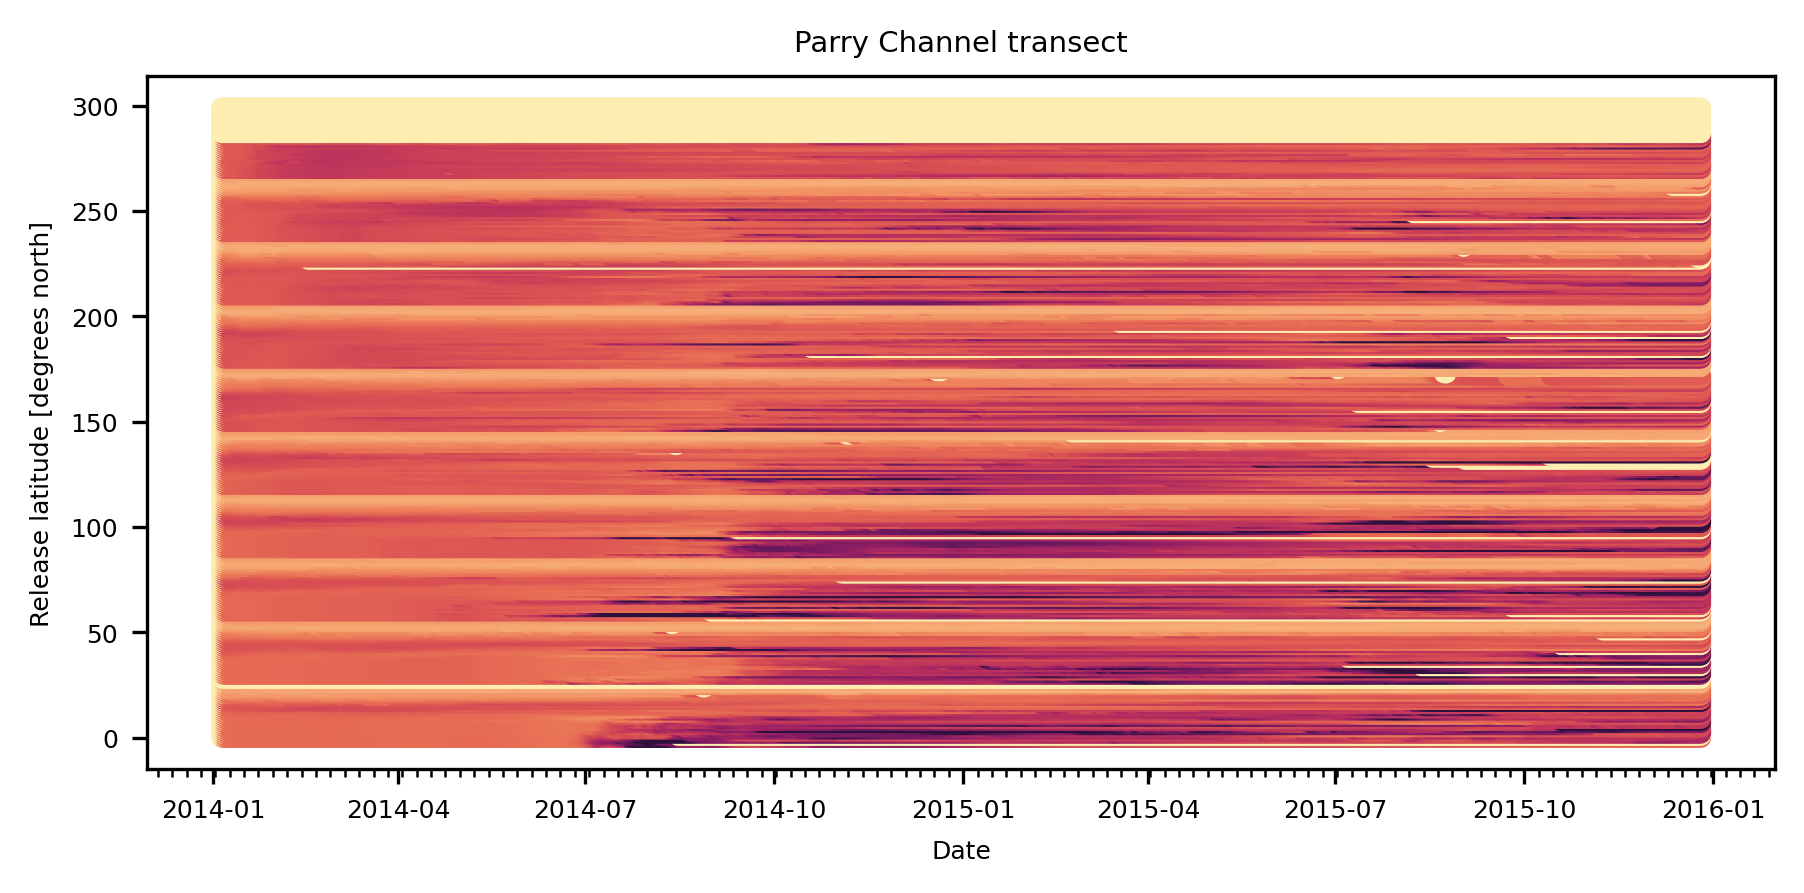

In [35]:
hovmoeller_simple(time_t1, lon_t1, lat_t1, dPb_t1, vmin=0, vmax=10)

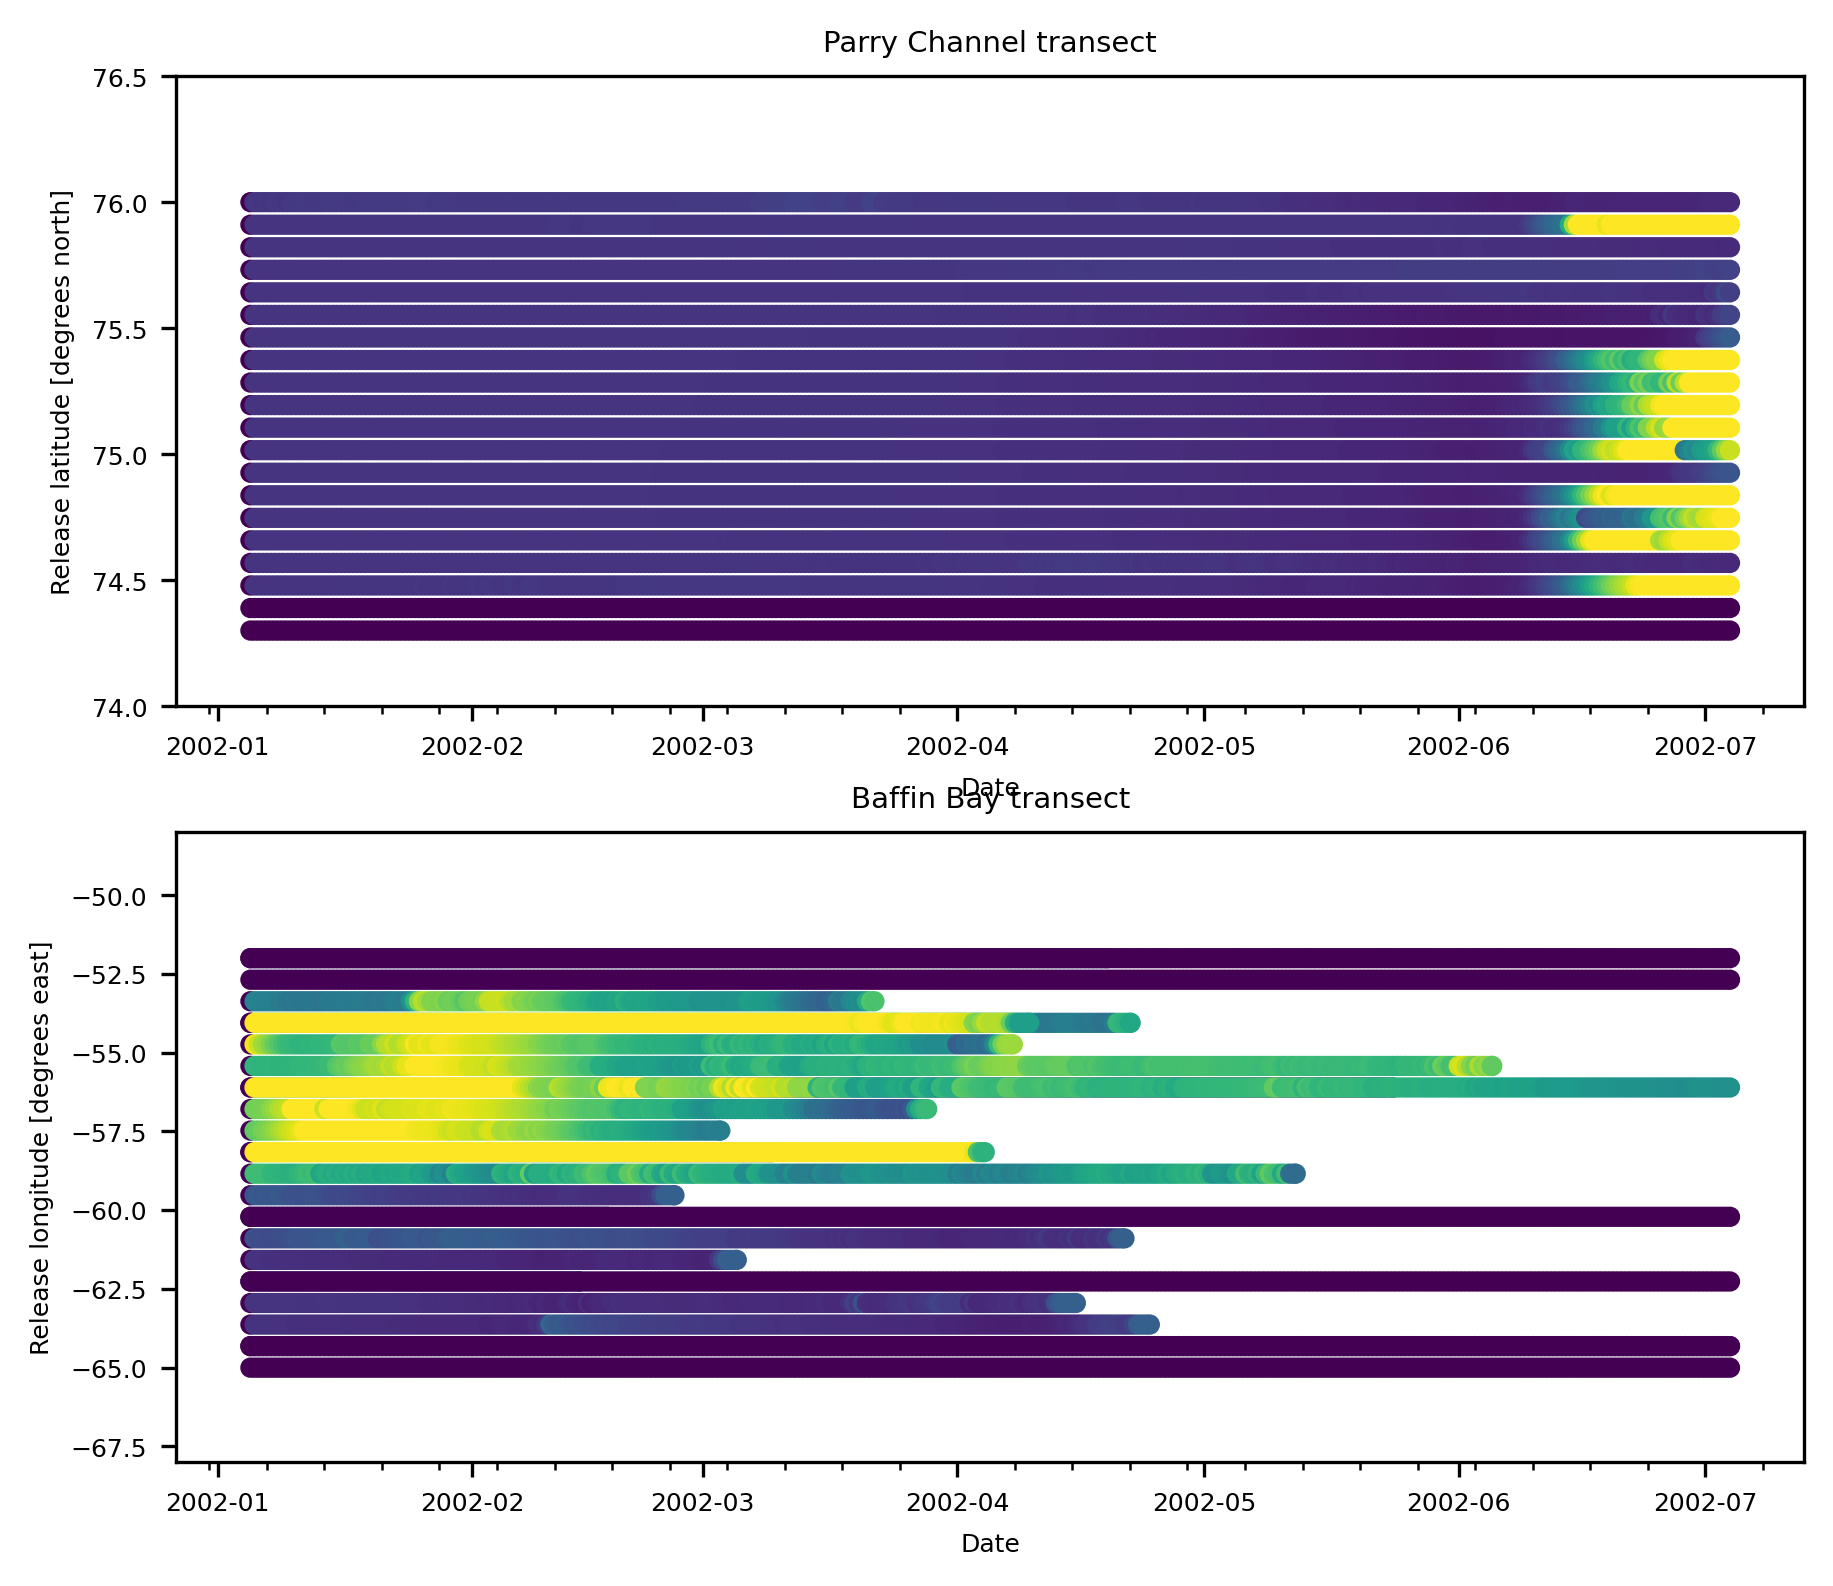

In [121]:
hovmoeller_simple(time_t1, lon_t1, lat_t1, traj_t1, dPb_t1)

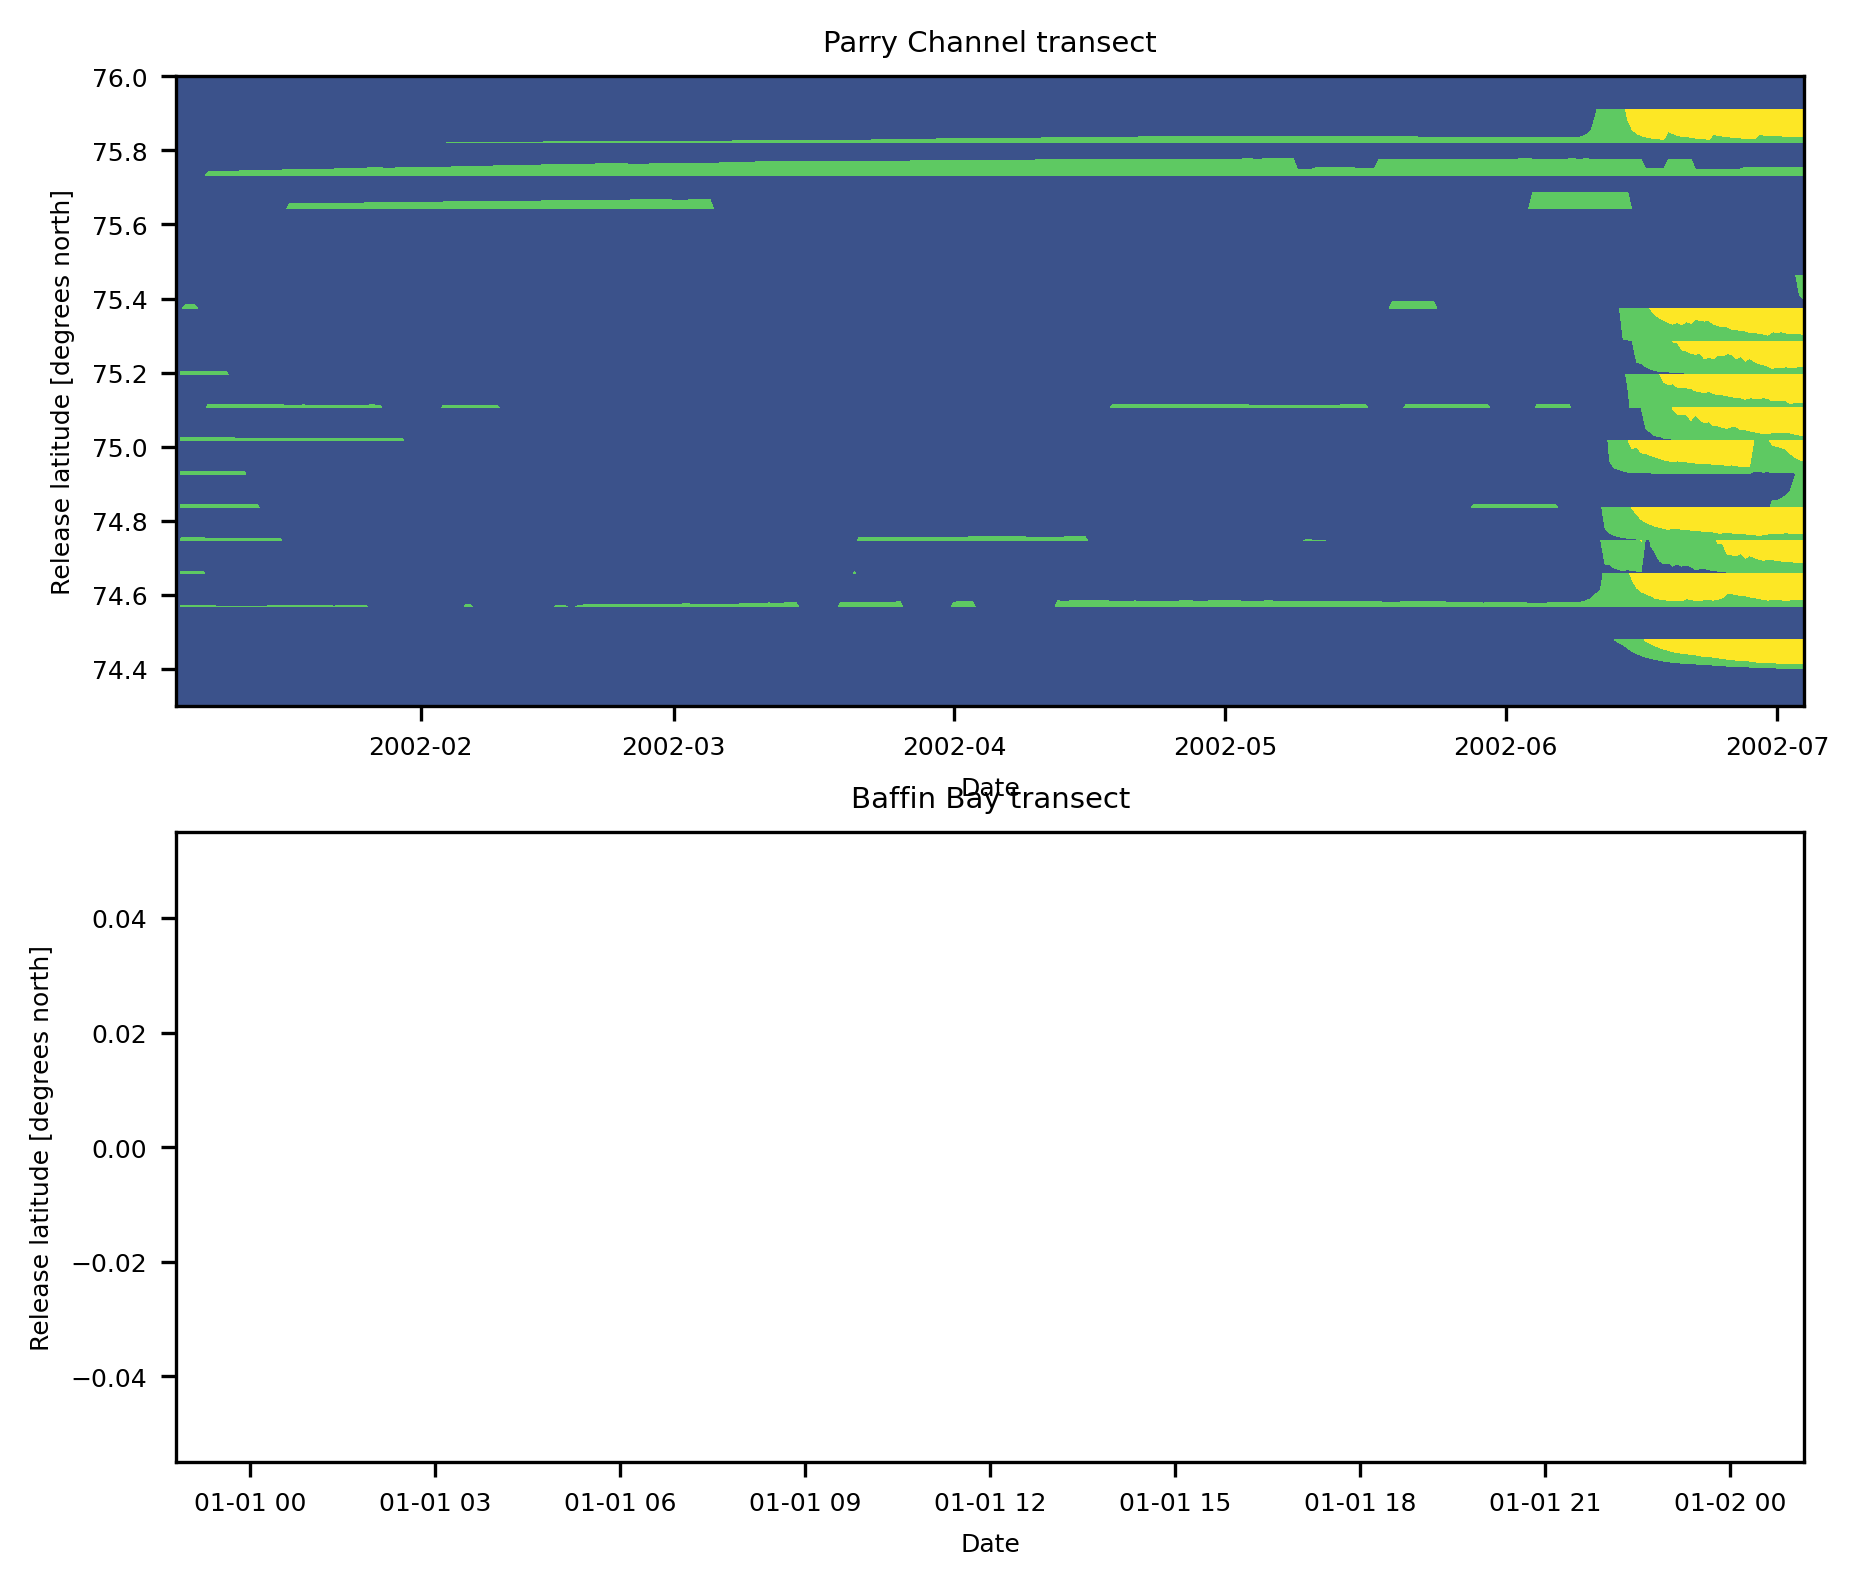

In [81]:
hovmoeller(time_t1, lon_t1, lat_t1, traj_t1, dPb_t1)